In [30]:
import numpy as np
import pandas as pd
import math
%matplotlib inline
import pandas_datareader
import datetime
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

In [26]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2021, 1, 1)
tesla_df = web.DataReader("TSLA", 'yahoo', start, end)

In [27]:
tesla_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900,5.530,5.788,5.616,4640500.0,5.616
2012-01-04,5.734,5.500,5.642,5.542,3150500.0,5.542
2012-01-05,5.586,5.370,5.552,5.424,5027500.0,5.424
2012-01-06,5.558,5.282,5.440,5.382,4931500.0,5.382
2012-01-09,5.498,5.224,5.400,5.450,4485000.0,5.450


Text(0, 0.5, 'Close Price USD ($)')

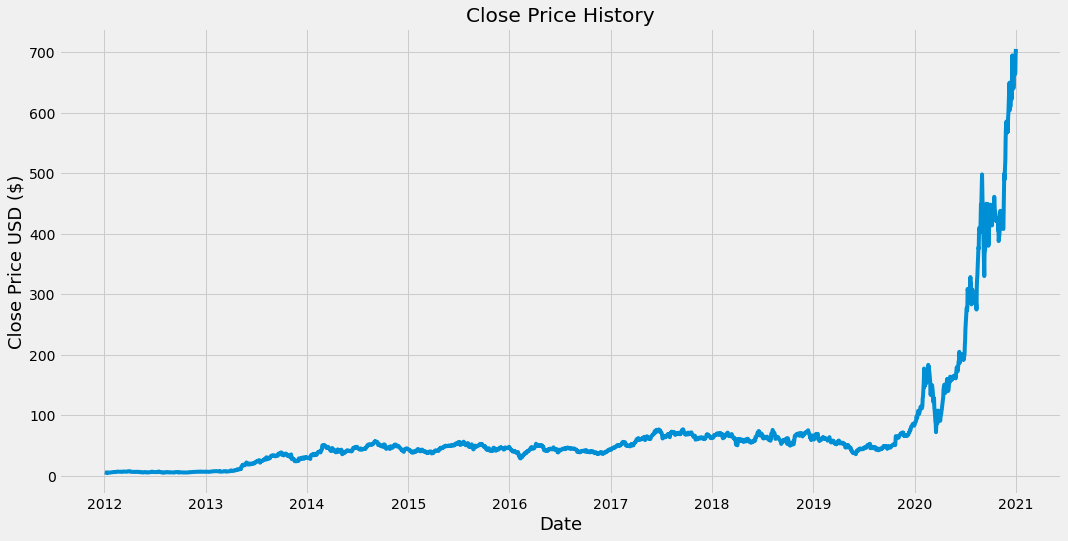

In [28]:
## Visualise the closing price history 
plt.figure(figsize=(16,8)) # Size of figure 
plt.title('Close Price History') # Title of plot 
plt.plot(tesla_df['Close']) # Implement plot with some data
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

In [31]:
## Create a new dataframe with only the close column
data = tesla_df.filter(['Close'])
## Convert the dataframe to a numpy array 
dataset = data.values 
## Get the number of rows to train the model on 
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

1812

In [32]:
## Scale the data, make it between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00150903],
       [0.00140348],
       [0.00123518],
       ...,
       [0.9434042 ],
       [0.9844676 ],
       [1.        ]])

In [33]:
## Create the training data set 
## Create the scaled training data set 
train_data = scaled_data[0:training_data_len, :]
## Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 90:
        print(x_train)
        print(y_train)
        print()
## The x_train contains the past 60 values we are using to train, while the y_train value contains the 61st value that
## want our model to predict

[array([0.00150903, 0.00140348, 0.00123518, 0.00117528, 0.00127226,
       0.00137781, 0.00155182, 0.00155753, 0.        , 0.00108685,
       0.00114675, 0.00113249, 0.00108685, 0.00113534, 0.00132076,
       0.00147765, 0.00175436, 0.00186561, 0.00193407, 0.00179144,
       0.00193692, 0.00212805, 0.00238478, 0.0025702 , 0.00251315,
       0.00260729, 0.00279271, 0.00237052, 0.00248177, 0.00296101,
       0.00308367, 0.00324912, 0.00347448, 0.00334041, 0.00326053,
       0.00334897, 0.00312646, 0.00308938, 0.00314358, 0.00302947,
       0.00331473, 0.00320919, 0.00313217, 0.0029439 , 0.00294675,
       0.00293248, 0.00340887, 0.00377115, 0.00379397, 0.00356576,
       0.00348304, 0.00357432, 0.00347733, 0.00347163, 0.00352583,
       0.00331188, 0.0032206 , 0.00416767, 0.00432171, 0.00429603,
       0.0041477 , 0.00412202, 0.00393375, 0.00434167, 0.00348304,
       0.0033347 , 0.00295531, 0.00275848, 0.00293819, 0.00303803,
       0.00308082, 0.00269857, 0.00269572, 0.00281553, 0.0029

In [34]:

## Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [35]:

## Reshape the data, as the LSTM expects the data to come in as 3D, as it is now currently 2D
x_train.shape # shows that it only has two values, hence 2D

(1722, 90)

In [36]:

## Reshape the data into a 3D array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1722, 90, 1)

In [37]:
## Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [38]:
## Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
## Train the model 
model.fit(x_train, y_train, batch_size=1, epochs=1)

1722/1722 [==============================] - 38s 20ms/step - loss: 1.0259e-04


In [40]:
## Create the testing data set 
## Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 90: , :]
## Create the data sets x_test and y_test 
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(90, len(test_data)):
    x_test.append(test_data[i-90:i, 0])

In [41]:
## Convert the data to a numpy array
x_test = np.array(x_test)

In [42]:
## Reshape the data because it is currently 2D and needs to be 3D 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [43]:
## Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [44]:
## Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

15.698546420133141

<ipython-input-45-cc2bb1827526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


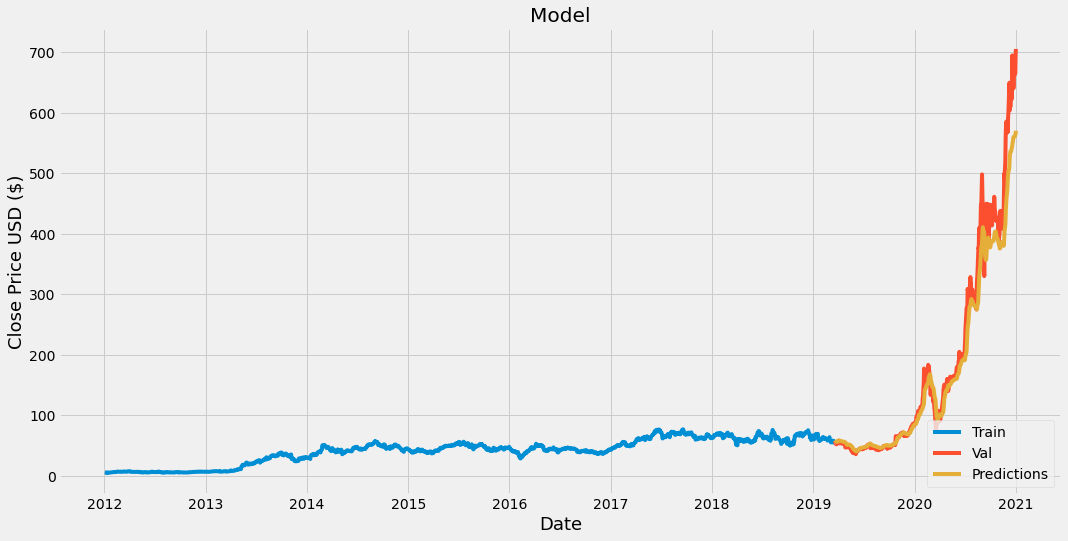

In [45]:
## Plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions 
## Visualise the data 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [46]:
## Show the valid or actual price and predicted prices 
valid

,Close,Predictions
Date,,
2019-03-19,53.493999,58.705978
2019-03-20,54.720001,58.107819
2019-03-21,54.804001,57.689308
2019-03-22,52.905998,57.417416
2019-03-25,52.084000,57.009300
...,...,...
2020-12-24,661.770020,560.311584
2020-12-28,663.690002,561.592102
2020-12-29,665.989990,563.431885
